In [ ]:
import os
import sys
import json
import logging
import warnings
import joblib
from pathlib import Path
from datetime import datetime

import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
import lightgbm as lgb

from lightgbm import LGBMClassifier, plot_importance
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    roc_curve,
    f1_score,
    brier_score_loss,
)
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

c:\Users\rajes\OneDrive\Documents\tech-test\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
CONFIG = {
    "data_dir": ".",
    "customer_info_path": "customer_info.parquet",
    "usage_path": "usage.parquet",
    "calls_path": "calls.csv",
    "cease_path": "cease.csv",
    "target_col": "churned",
    "id_col": "unique_customer_identifier",
    "test_size": 0.2,
    "random_state": 42,
    "optuna_trials": 30,
    "artefact_dir": "artefacts",
}

Path(CONFIG["artefact_dir"]).mkdir(exist_ok=True)

In [ ]:
conn = duckdb.connect("telecom.duckdb")

conn.execute("""
PRAGMA threads=4;
PRAGMA memory_limit='6GB';
PRAGMA temp_directory='duckdb_tmp';
PRAGMA max_temp_directory_size='20GB';
""")

print("DuckDB connected")

# ============================================================
#  CREATE DATA VIEWS 
# ============================================================

conn.execute("""
CREATE OR REPLACE VIEW customer_info AS
SELECT * FROM read_parquet('customer_info.parquet')
""")

conn.execute("""
CREATE OR REPLACE VIEW usage_data AS
SELECT * FROM read_parquet('usage.parquet')
""")

conn.execute("""
CREATE OR REPLACE VIEW calls_data AS
SELECT * FROM read_csv_auto('calls.csv')
""")

conn.execute("""
CREATE OR REPLACE VIEW cease_data AS
SELECT * FROM read_csv_auto('cease.csv')
""")

print("Views created successfully")

# ============================================================
# QUICK VALIDATION (NO FULL LOAD)
# ============================================================

customer_count = conn.execute("""
SELECT COUNT(*) FROM customer_info
""").fetchone()[0]

usage_count = conn.execute("""
SELECT COUNT(*) FROM usage_data
""").fetchone()[0]

calls_count = conn.execute("""
SELECT COUNT(*) FROM calls_data
""").fetchone()[0]

cease_count = conn.execute("""
SELECT COUNT(*) FROM cease_data
""").fetchone()[0]

print("Customer rows:", customer_count)
print("Usage rows:", usage_count)
print("Calls rows:", calls_count)
print("Cease rows:", cease_count)


DuckDB connected
Views created successfully
Customer rows: 3545538
Usage rows: 83185050
Calls rows: 628437
Cease rows: 146363


STEP 2: AUTOMATED EDA

---- CUSTOMER_INFO ----
Shape: (20000, 12)

Dtypes:
unique_customer_identifier            object
datevalue                     datetime64[us]
contract_status                       object
contract_dd_cancels                    int64
dd_cancel_60_day                       int32
ooc_days                             float64
technology                            object
speed                                  int32
line_speed                           float64
sales_channel                         object
crm_package_name                      object
tenure_days                            int32
dtype: object

Missing %:
unique_customer_identifier    0.00
datevalue                     0.00
contract_status               0.00
contract_dd_cancels           0.00
dd_cancel_60_day              0.00
ooc_days                      0.58
technology                    0.00
speed                         0.00
line_speed                    0.00
sales_channel                 0.00
crm_packa

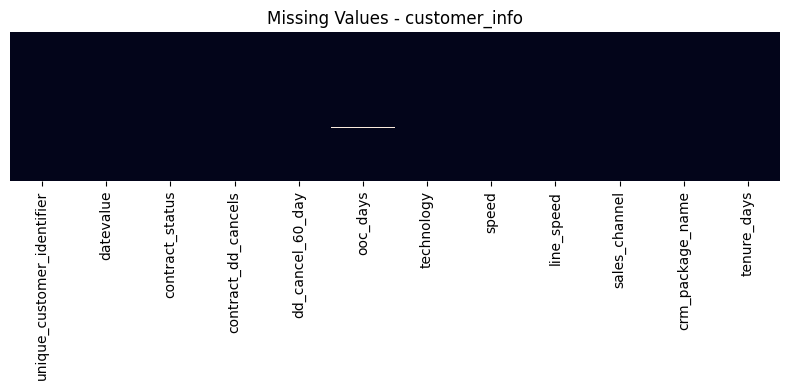

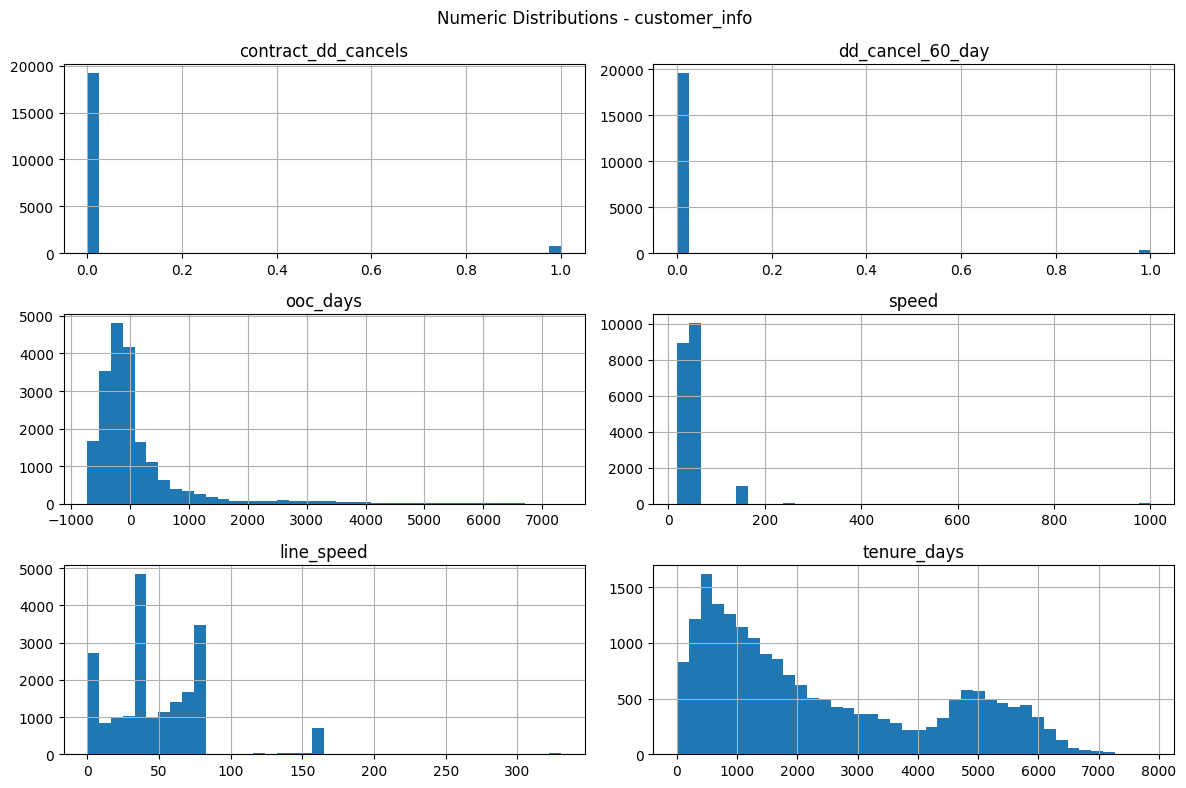


---- USAGE ----
Shape: (20000, 4)

Dtypes:
unique_customer_identifier            object
calendar_date                 datetime64[us]
usage_download_mbs                    object
usage_upload_mbs                      object
dtype: object

Missing %:
unique_customer_identifier    0.0
calendar_date                 0.0
usage_download_mbs            0.0
usage_upload_mbs              0.0
dtype: float64

---- CALLS ----
Shape: (20000, 5)

Dtypes:
unique_customer_identifier            object
event_date                    datetime64[us]
call_type                             object
talk_time_seconds                    float64
hold_time_seconds                    float64
dtype: object

Missing %:
unique_customer_identifier    0.0
event_date                    0.0
call_type                     0.0
talk_time_seconds             0.0
hold_time_seconds             0.0
dtype: float64


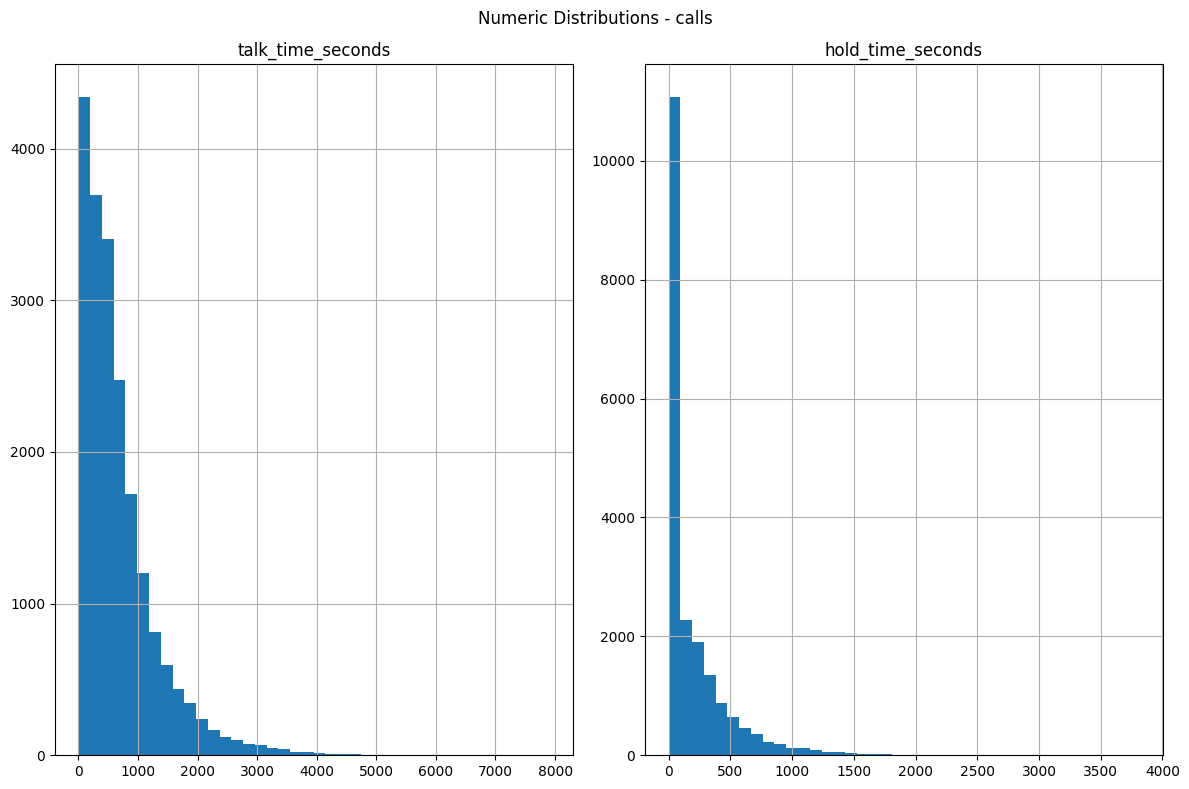


---- CEASE ----
Shape: (146363, 5)

Dtypes:
unique_customer_identifier            object
cease_placed_date             datetime64[us]
cease_completed_date                  object
reason_description                    object
reason_description_insight            object
dtype: object

Missing %:
unique_customer_identifier    0.0
cease_placed_date             0.0
cease_completed_date          0.0
reason_description            0.0
reason_description_insight    0.0
dtype: float64

CLASS IMBALANCE
Total customers: 202782
Churned: 130934
Churn rate: 64.57 %


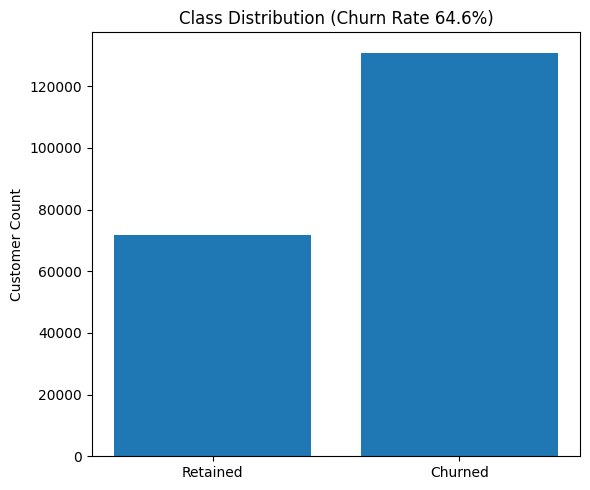


EDA plots saved to: artefacts\eda_plots


In [ ]:
# ============================================================
# AUTOMATED EDA (DUCKDB VERSION)
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

EDA_DIR = Path("artefacts/eda_plots")
EDA_DIR.mkdir(parents=True, exist_ok=True)

print("="*60)
print("STEP 2: AUTOMATED EDA")
print("="*60)

# ------------------------------------------------------------
# SAMPLE DATA FROM DUCKDB (IMPORTANT FOR PERFORMANCE)
# ------------------------------------------------------------

customer_df = conn.execute("""
SELECT * FROM customer_info USING SAMPLE 20000 ROWS
""").fetchdf()

usage_df = conn.execute("""
SELECT * FROM usage_data USING SAMPLE 20000 ROWS
""").fetchdf()

calls_df = conn.execute("""
SELECT * FROM calls_data USING SAMPLE 20000 ROWS
""").fetchdf()

cease_df = conn.execute("""
SELECT * FROM cease_data
""").fetchdf()

data = {
    "customer_info": customer_df,
    "usage": usage_df,
    "calls": calls_df,
    "cease": cease_df
}

# ------------------------------------------------------------
# BASIC SUMMARY + MISSING ANALYSIS
# ------------------------------------------------------------

for name, df in data.items():

    print(f"\n---- {name.upper()} ----")
    print("Shape:", df.shape)
    print("\nDtypes:")
    print(df.dtypes)
    print("\nMissing %:")
    print((df.isnull().mean()*100).round(2))

    # Missing Heatmap
    if df.isnull().any().any():
        plt.figure(figsize=(max(8,len(df.columns)//2),4))
        sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
        plt.title(f"Missing Values - {name}")
        plt.tight_layout()
        plt.savefig(EDA_DIR / f"missing_{name}.png")
        plt.show()

    # Numeric distributions
    num_cols = df.select_dtypes(include=[np.number]).columns

    if len(num_cols) > 0:
        df[num_cols].hist(figsize=(12,8), bins=40)
        plt.suptitle(f"Numeric Distributions - {name}")
        plt.tight_layout()
        plt.savefig(EDA_DIR / f"distribution_{name}.png")
        plt.show()


# ------------------------------------------------------------
# CLASS IMBALANCE ANALYSIS
# ------------------------------------------------------------

total_customers = conn.execute("""
SELECT COUNT(DISTINCT unique_customer_identifier)
FROM customer_info
""").fetchone()[0]

churned_customers = conn.execute("""
SELECT COUNT(DISTINCT unique_customer_identifier)
FROM cease_data
""").fetchone()[0]

non_churned = total_customers - churned_customers
churn_rate = churned_customers / total_customers * 100

print("\nCLASS IMBALANCE")
print("Total customers:", total_customers)
print("Churned:", churned_customers)
print("Churn rate:", round(churn_rate,2), "%")

plt.figure(figsize=(6,5))
plt.bar(["Retained","Churned"],
        [non_churned, churned_customers])
plt.title(f"Class Distribution (Churn Rate {churn_rate:.1f}%)")
plt.ylabel("Customer Count")
plt.tight_layout()
plt.savefig(EDA_DIR / "class_imbalance.png")
plt.show()

print(f"\nEDA plots saved to: {EDA_DIR}")


In [ ]:
# ============================================================
# FEATURE ENGINEERING (DUCKDB VERSION - FAST)
# ============================================================

# -----------------------------
# USAGE AGGREGATION
# -----------------------------

conn.execute("""
CREATE OR REPLACE TABLE usage_agg AS
SELECT
    unique_customer_identifier,

    SUM(CAST(usage_download_mbs AS DOUBLE))/1024.0
        AS usage_total_download_gb,

    SUM(CAST(usage_upload_mbs AS DOUBLE))/1024.0
        AS usage_total_upload_gb,

    AVG(CAST(usage_download_mbs AS DOUBLE))
        AS usage_avg_download,

    SUM(
        CASE
            WHEN CAST(usage_download_mbs AS DOUBLE) = 0 THEN 1
            ELSE 0
        END
    ) AS usage_zero_days

FROM usage_data
GROUP BY unique_customer_identifier
""")


conn.execute("""
ALTER TABLE usage_agg ADD COLUMN usage_dl_ul_ratio DOUBLE
""")

conn.execute("""
UPDATE usage_agg
SET usage_dl_ul_ratio =
    usage_total_download_gb /
    NULLIF(usage_total_upload_gb, 0)
""")

print("Usage features created")


# -----------------------------
# CALL AGGREGATION
# -----------------------------

conn.execute("""
CREATE OR REPLACE TABLE calls_agg AS
SELECT
    unique_customer_identifier,

    COUNT(*) AS calls_total,
    AVG(talk_time_seconds) AS calls_avg_talk,
    SUM(hold_time_seconds) AS calls_total_hold,

    SUM(hold_time_seconds) /
    NULLIF(AVG(talk_time_seconds),0) AS hold_to_talk_ratio

FROM calls_data
GROUP BY unique_customer_identifier
""")

print("Call features created")


# -----------------------------
# CUSTOMER SNAPSHOT
# -----------------------------

conn.execute("""
CREATE OR REPLACE TABLE customer_snap AS
SELECT *
FROM (
    SELECT *,
           ROW_NUMBER() OVER (
               PARTITION BY unique_customer_identifier
               ORDER BY datevalue DESC
           ) AS rn
    FROM customer_info
)
WHERE rn = 1
""")

conn.execute("""
ALTER TABLE customer_snap ADD COLUMN speed_gap DOUBLE
""")

conn.execute("""
UPDATE customer_snap
SET speed_gap = speed - line_speed
""")

conn.execute("""
ALTER TABLE customer_snap ADD COLUMN is_out_of_contract INTEGER
""")

conn.execute("""
UPDATE customer_snap
SET is_out_of_contract = CASE WHEN ooc_days > 0 THEN 1 ELSE 0 END
""")

print("Customer snapshot created")


# -----------------------------
# CHURN FLAG
# -----------------------------

conn.execute("""
CREATE OR REPLACE TABLE churn_flag AS
SELECT DISTINCT
    unique_customer_identifier,
    1 AS churned
FROM cease_data
""")


# -----------------------------
# FINAL MODELLING TABLE
# -----------------------------

conn.execute("""
CREATE OR REPLACE TABLE modelling_table AS
SELECT
    cs.*,
    COALESCE(cf.churned,0) AS churned,
    ua.* EXCLUDE(unique_customer_identifier),
    ca.* EXCLUDE(unique_customer_identifier)

FROM customer_snap cs

LEFT JOIN churn_flag cf
ON cs.unique_customer_identifier = cf.unique_customer_identifier

LEFT JOIN usage_agg ua
ON cs.unique_customer_identifier = ua.unique_customer_identifier

LEFT JOIN calls_agg ca
ON cs.unique_customer_identifier = ca.unique_customer_identifier
""")

print("Final modelling table created")


# -----------------------------
# LOAD ONLY FINAL DATA TO PANDAS
# -----------------------------

df = conn.execute("""
SELECT * FROM modelling_table
""").fetchdf()

print("Final dataset:", df.shape)


Usage features created
Call features created
Customer snapshot created
Final modelling table created
Final dataset: (202782, 25)


In [ ]:
# ============================================================
# PREPROCESSING
# ============================================================

DROP_COLS = [
    "unique_customer_identifier",
    "datevalue",
    "churned"
]

CATEGORICAL_COLS = [
    "contract_status",
    "technology",
    "sales_channel"
]

X = df.drop(columns=DROP_COLS)
y = df["churned"]

for col in CATEGORICAL_COLS:
    if col in X.columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

X = X.select_dtypes(include=[np.number])

In [ ]:
# ============================================================
# TRAIN TEST SPLIT
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=CONFIG["test_size"],
    stratify=y,
    random_state=CONFIG["random_state"]
)

scale_pos_weight = (y_train==0).sum()/(y_train==1).sum()


In [ ]:
# ============================================================
# MODEL TRAINING
# ============================================================

model = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 104747, number of negative: 57478
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3138
[LightGBM] [Info] Number of data points in the train set: 162225, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.645690 -> initscore=0.600146
[LightGBM] [Info] Start training from score 0.600146


,boosting_type,'gbdt'
,num_leaves,64
,max_depth,-1
,learning_rate,0.05
,n_estimators,600
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


ROC-AUC: 0.9727

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.92      0.89     14370
           1       0.96      0.91      0.93     26187

    accuracy                           0.92     40557
   macro avg       0.90      0.92      0.91     40557
weighted avg       0.92      0.92      0.92     40557



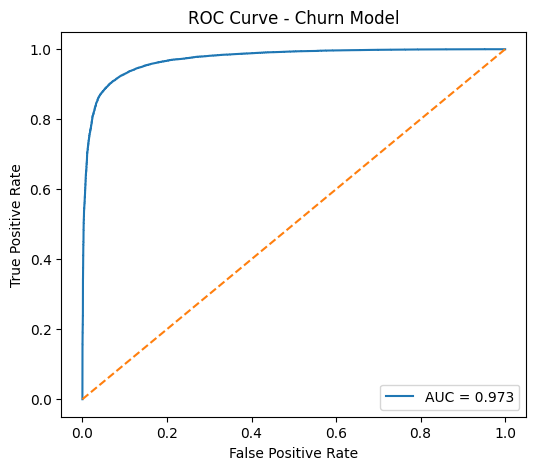

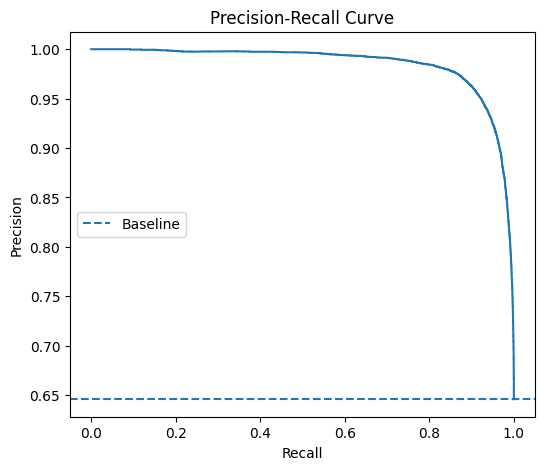

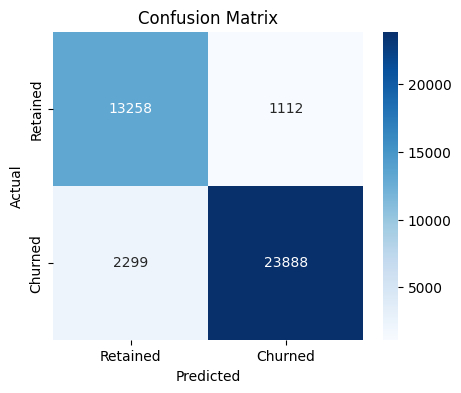

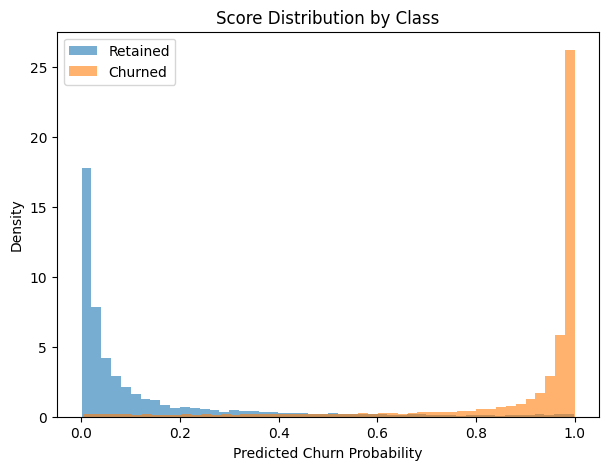

In [ ]:
# ============================================================
# EVALUATION 
# ============================================================

from sklearn.metrics import roc_curve, precision_recall_curve

preds = model.predict_proba(X_test)[:,1]
pred_label = (preds > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, preds)

print("ROC-AUC:", round(roc_auc,4))
print("\nClassification Report")
print(classification_report(y_test, pred_label))


# ------------------------------------------------------------
# ROC CURVE
# ------------------------------------------------------------

fpr, tpr, _ = roc_curve(y_test, preds)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Churn Model")
plt.legend()
plt.show()


# ------------------------------------------------------------
#  PRECISION RECALL CURVE
# ------------------------------------------------------------

precision, recall, _ = precision_recall_curve(y_test, preds)

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.axhline(y_test.mean(), linestyle="--", label="Baseline")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


# ------------------------------------------------------------
# CONFUSION MATRIX (HEATMAP)
# ------------------------------------------------------------

cm = confusion_matrix(y_test, pred_label)

plt.figure(figsize=(5,4))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Retained","Churned"],
            yticklabels=["Retained","Churned"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# ------------------------------------------------------------
# SCORE DISTRIBUTION
# ------------------------------------------------------------

plt.figure(figsize=(7,5))

plt.hist(preds[y_test==0],
         bins=50,
         alpha=0.6,
         label="Retained",
         density=True)

plt.hist(preds[y_test==1],
         bins=50,
         alpha=0.6,
         label="Churned",
         density=True)

plt.xlabel("Predicted Churn Probability")
plt.ylabel("Density")
plt.title("Score Distribution by Class")
plt.legend()
plt.show()


In [ ]:
# ============================================================
# TOP 20% RISK SEGMENT
# ============================================================

threshold = np.percentile(preds, 80)

test_results = df.loc[X_test.index].copy()
test_results["risk_score"] = preds
test_results["high_risk_flag"] = (preds >= threshold).astype(int)

print("\nTop High Risk Customers")
print(test_results.sort_values("risk_score", ascending=False)[
    ["unique_customer_identifier","risk_score","churned"]
].head(10))



Top High Risk Customers
                               unique_customer_identifier  risk_score  churned
149469  43693914c7fcf23b5eece137495294d36e0e6c4d440f7b...    0.999946        1
2958    94338069463c472bee39f00d4aa0e4df488b5353f09040...    0.999924        1
58304   73ce479a1f42a7cc35fd4927cc4b68af65ebf41242db94...    0.999902        1
193106  83024aaf3fd62d28133dfb550782fd2791471970616060...    0.999884        1
26412   10180b5d0347957b45e27f97aa0fb226476d23516b270b...    0.999883        1
195006  e1505600c3e357cad96e09e2fdad7dfb9029250d4d86f1...    0.999862        1
106542  685cf8825c2e6bb63171a15cd682a727f96afb06231b10...    0.999861        1
109978  d54ddf564d83c00029f332e8a1ba014f12d96b9af52bcc...    0.999853        1
103705  0ea61073408a5c50c441ab09746074013d232deceadd10...    0.999840        1
144251  6a5c00e18ac9ae15e0b27caf25ddfb2275b0098c1c9bd6...    0.999823        1


In [20]:
top_20 = test_results[test_results["high_risk_flag"] == 1]
recall_20 = top_20["churned"].sum() / test_results["churned"].sum()
print("Recall at Top 20%:", recall_20)

Recall at Top 20%: 0.30912284721426664


In [21]:
baseline_rate = test_results["churned"].mean()
top_20_rate = top_20["churned"].mean()
lift = top_20_rate / baseline_rate
print("Lift:", lift)

Lift: 1.545499915491742


<Figure size 1000x600 with 0 Axes>

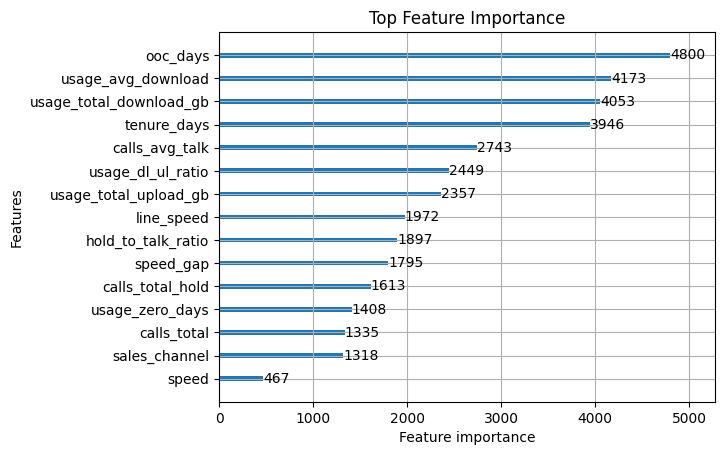

In [ ]:
# ============================================================
# FEATURE IMPORTANCE
# ============================================================

plt.figure(figsize=(10,6))
plot_importance(model, max_num_features=15)
plt.title("Top Feature Importance")
plt.show()


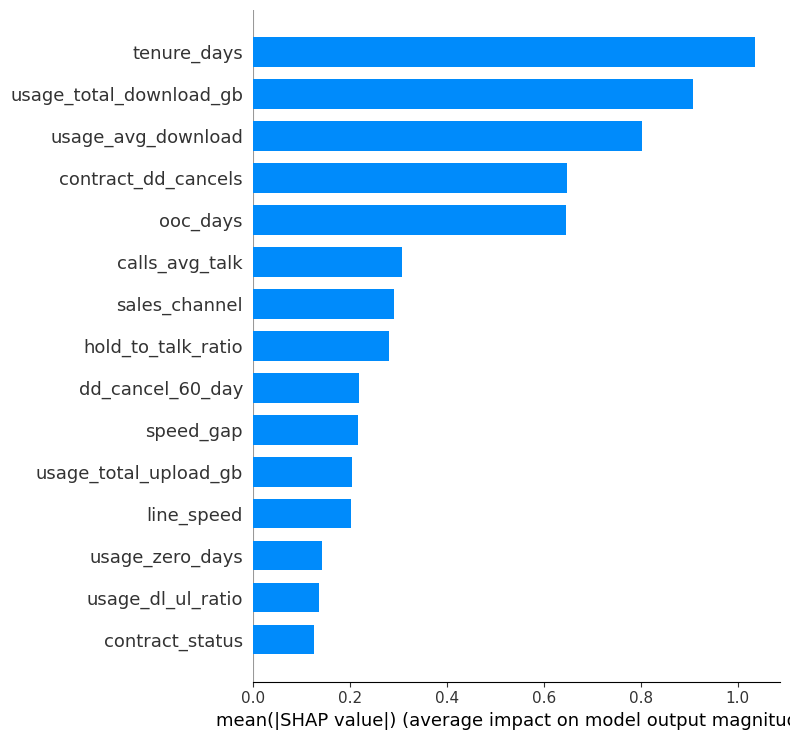

In [ ]:
# ============================================================
# SHAP EXPLANATION
# ============================================================
X_test_sample = X_test.sample(min(2000, len(X_test)))
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test.sample(min(2000,len(X_test))))

shap.summary_plot(shap_values, X_test_sample, plot_type="bar", max_display=15)

In [ ]:
# ============================================================
# SAVE MODEL
# ============================================================

joblib.dump(model, "lgbm_churn_model.pkl")

['lgbm_churn_model.pkl']